# Signal quality metrics and channel rejection

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Visual inspection](#section_1_3)
        * [Physiological noise](#sub_section_1_3_1)
        * [Spikes](#sub_section_1_3_2)
        * [Baseline shifts](#sub_section_1_3_3)
        * [Baseline drift](#sub_section_1_3_4)
    * [Signal quality metrics and channel rejection](#section_1_4)
        * [Scalp Coupling Index](#sub_section_1_4_2)
        * [Peak Spectral Power](#sub_section_1_4_3)
        * [Signal-to-Noise Ratio](#sub_section_1_4_4) 
        * [Coefficient of Variation](#sub_section_1_4_5) 
        * [Contrast-to-Noise Ratio](#sub_section_1_4_6)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne.preprocessing import ICA, corrmap
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr
from scipy.signal import wiener
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import dataframe_image as dfi

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_20736\2406276141.py:21: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own functions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

def plot_SNR(raw, scores, times, threshold=0.1):
    """
    Plot time x channel based quality metrics.

    The left figure shows the raw score per channel and time.

    Parameters
    ----------
    raw : instance of Raw
        The haemoglobin data.
    scores : array
        The quality metric scores.
    times : list of pairs
        Start and end time for each quality metric.
    threshold : float
        Value below which a segment will be marked as bad.
    title : str
        Title of plot. If not specified a default title will be used.

    Returns
    -------
    fig : figure
        Matplotlib figure displaying raw scores and thresholded scores.
    """

    ch_names = raw.ch_names

    cols = [np.round(t[0]) for t in times]

    title = 'SNR'

    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))

    n_chans = len(ch_names)
    vsize = 0.2 * n_chans

    # First, plot the "raw" scores.
    fig, ax = plt.subplots(1, 2, figsize=(20, vsize), layout='constrained')
    fig.suptitle(title, fontsize=16, fontweight='bold')
    sns.heatmap(data=data_to_plot, cmap='Reds_r', vmin=np.min(scores), vmax=np.max(scores),
                cbar_kws=dict(label='Score'), ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[0].set_title('All Scores', fontweight='bold')
    markbad(raw, ax[0])

    # Now, adjust the color range to highlight segments that exceeded the
    # limit.

    data_to_plot = pd.DataFrame(data=scores > threshold,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    sns.heatmap(data=data_to_plot, vmin=0, vmax=1,
                cmap='Reds_r', cbar_kws=dict(label='Score'), ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[1].set_title('Scores < Limit', fontweight='bold')
    markbad(raw, ax[1])

    return fig

def markbad(raw, ax):

    [ax.axhline(y + 0.5, ls='solid', lw=2, color='black') for y in np.where([ch in raw.info['bads'] for ch in raw.ch_names])[0]]

    return ax

def plot_CV(raw, scores, times, threshold=0.1):
    """
    Plot time x channel based quality metrics.

    The left figure shows the raw score per channel and time.

    Parameters
    ----------
    raw : instance of Raw
        The haemoglobin data.
    scores : array
        The quality metric scores.
    times : list of pairs
        Start and end time for each quality metric.
    threshold : float
        Value below which a segment will be marked as bad.
    title : str
        Title of plot. If not specified a default title will be used.

    Returns
    -------
    fig : figure
        Matplotlib figure displaying raw scores and thresholded scores.
    """

    ch_names = raw.ch_names
    cols = [np.round(t[0]) for t in times]

    title = 'CV'

    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))

    n_chans = len(ch_names)
    vsize = 0.2 * n_chans

    # First, plot the "raw" scores.
    fig, ax = plt.subplots(1, 2, figsize=(20, vsize), layout='constrained')
    fig.suptitle(title, fontsize=16, fontweight='bold')
    sns.heatmap(data=data_to_plot, cmap='Reds_r', vmin=np.min(scores), vmax=np.max(scores),
                cbar_kws=dict(label='Score'), ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[0].set_title('All Scores', fontweight='bold')
    markbad(raw, ax[0])

    # Now, adjust the color range to highlight segments that exceeded the
    # limit.

    data_to_plot = pd.DataFrame(data=scores < threshold,
                                columns=pd.Index(cols, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    sns.heatmap(data=data_to_plot, vmin=0, vmax=1,
                cmap='Reds_r', cbar_kws=dict(label='Score'), ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(times))]
    ax[1].set_title('Scores > Limit', fontweight='bold')
    markbad(raw, ax[1])

    return fig

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = True
# Export figures?
export = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
filename = 'FTT1.snirf'

In [5]:
# Read snirf data
raw = mne.io.read_raw_snirf(filename, optode_frame='unknown', preload=False, verbose=None)

Loading C:\Users\fabia\fNIRS data analysis\Notebooks Master Thesis - Fabian Duren\FTT analysis\FTT1\FTT1.snirf


In [6]:
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
raw_intensity = reorder(raw)

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [7]:
# Use self-written function to add info about the subject and the recording
annotations = {"1": "Baseline", "2": "Grasping/Right", "3": "Grasping/Left"}
raw_intensity = add_info(raw_intensity, 'Subject', '1', 26, 'male', 'right', annotations, 10, 60, 10)

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


In [8]:
# Look at characteristics
raw_intensity

<RawSNIRF | FTT1.snirf, 52 x 4394 (852.2 s), ~52 kB, data not loaded>

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


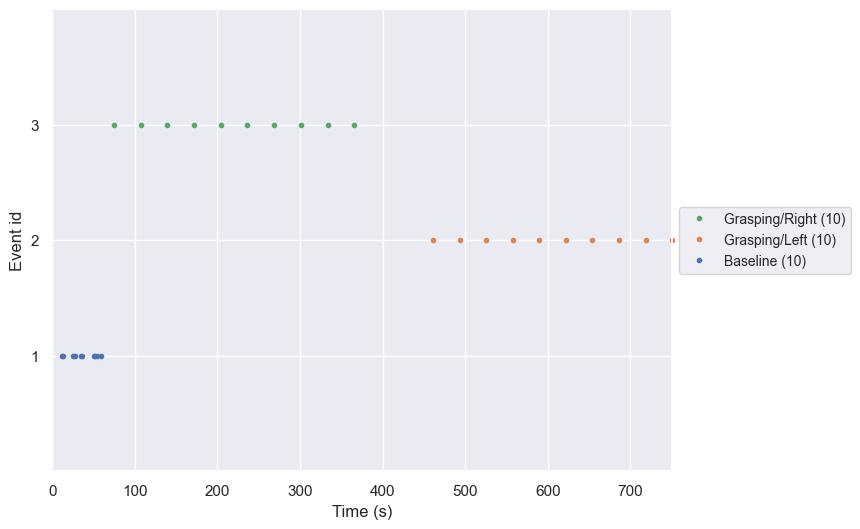

In [9]:
# Look at segments
events, event_dict = mne.events_from_annotations(raw_intensity)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq'])
if export:
    fig.savefig('events_FTT1.png')

In [10]:
# As a table
raw_intensity.annotations.to_data_frame()

,onset,duration,description
0,2024-02-15 13:12:48.000,10.0,Baseline
1,2024-02-15 13:12:49.000,10.0,Baseline
2,2024-02-15 13:13:01.000,10.0,Baseline
3,2024-02-15 13:13:04.000,10.0,Baseline
4,2024-02-15 13:13:11.000,10.0,Baseline
5,2024-02-15 13:13:12.000,10.0,Baseline
6,2024-02-15 13:13:27.000,10.0,Baseline
7,2024-02-15 13:13:28.000,10.0,Baseline
8,2024-02-15 13:13:30.000,10.0,Baseline
9,2024-02-15 13:13:35.000,10.0,Baseline


##### Adress problem with timing of fNIRS recordings

No stimulus presentation software was used to set-up this experiment. In the first finger-tapping task, the start and stop of each stimulus was given manually by the researcher. The stimulus duration was 10 seconds followed by a rest period of 20 seconds, before presenting the next stimuli. However, in the *.snirf* file the stimuli are not as expected.  This problem is related to the problem with the overall timing of the fNIRS recordings as explained in more detail in the **Timing problem** Notebook.

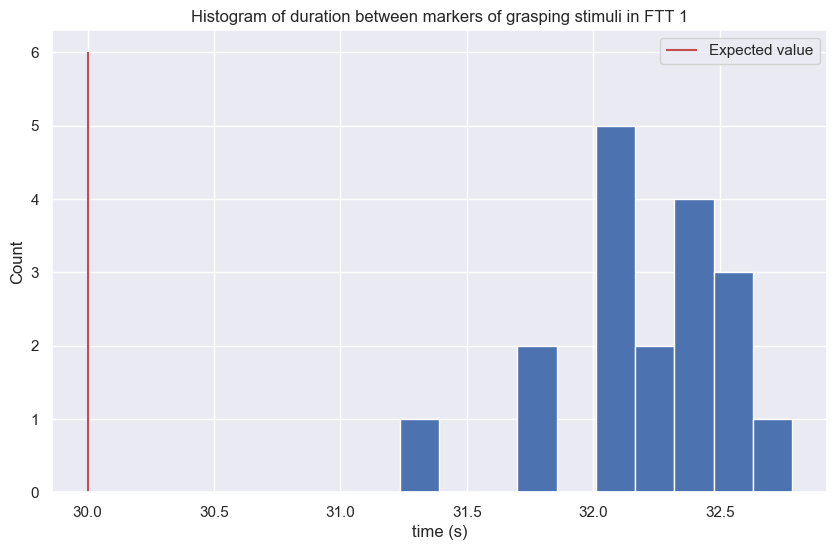

In [11]:
%matplotlib inline
# Determine duration between stimuli: expected to be 10 s + 20 s = 30 s
# Get IDs of test events
ids_left = event_dict['Grasping/Left']
ids_right = event_dict['Grasping/Right']
inter_stim_left = np.diff(events[np.isin(events[:,2], ids_left)][:,0])/raw_intensity.info['sfreq']
inter_stim_right = np.diff(events[np.isin(events[:,2], ids_right)][:,0])/raw_intensity.info['sfreq']
inter_stim = np.concatenate([inter_stim_left, inter_stim_right])
# plot
plt.hist(inter_stim)
plt.xlabel('time (s)')
plt.ylabel('Count')
plt.title('Histogram of duration between markers of grasping stimuli in FTT 1')
plt.vlines([30], ymin = 0, ymax = 6, color = 'r', label = 'Expected value')
plt.legend()
if export:
    plt.savefig('Timing_problem_FTT1.png')
    

---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- sample frequency = 5.15 Hz
- LPF = 2.58 Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
- The durations between the markers representing the grasping movement of the subject are not inline with the expected value. However, this could be due to mistakes made by the researcher as the markers were set manually.
---

### Visual inspection <a class="anchor" id="section_1_3"></a>

##### Validate that the location of sources-detector pairs and channels are in the expected locations

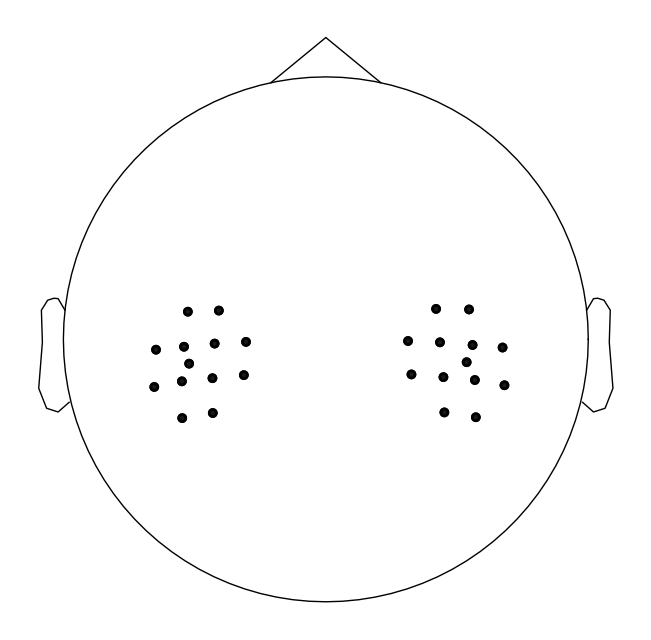

In [12]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensity.plot_sensors();

In [13]:
sns.set_theme()
if plot:
    # Plot channels in 3D
    subjects_dir = mne.datasets.sample.data_path() / "subjects"
    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

    brain = mne.viz.Brain("fsaverage", subjects_dir=subjects_dir, alpha=0.5, cortex="low_contrast")
    brain.add_head()
    
    identity_trans = mne.transforms.Transform("head", "mri") #transformed coord
    brain.add_sensors(raw_intensity.info, trans=identity_trans, fnirs=["channels", "pairs", "sources", "detectors"])

    # Add ROI: BA 1, 2, 3 - Primary somatosensory cortex (postcentral gyrus)
            # BA 4 - Primary motor cortex (precentral gyrus)
            # BA 5 - Somatosensory association cortex (NOT PRESENT IN LABELS)
            # BA 6	Premotor and supplementary motor cortex
    brain.add_label("BA1", hemi = "lh", borders=False, color='red')
    brain.add_label("BA1", hemi = "rh", borders=False, color='red')
    brain.add_label("BA2", hemi = "rh", borders=False, color='orange')
    brain.add_label("BA2", hemi = "lh", borders=False, color='orange')
    brain.add_label("BA3a", hemi = "rh", borders=False, color='yellow')
    brain.add_label("BA3b", hemi = "rh", borders=False, color='yellow')
    brain.add_label("BA3a", hemi = "lh", borders=False, color='yellow')
    brain.add_label("BA3b", hemi = "lh", borders=False, color='yellow')
    brain.add_label("BA4a", hemi = "lh", borders=False, color='green')
    brain.add_label("BA4a", hemi = "rh", borders=False, color='green')
    brain.add_label("BA4p", hemi = "lh", borders=False, color='green')
    brain.add_label("BA4p", hemi = "rh", borders=False, color='green')
    brain.add_label("BA6", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA6", hemi = "rh", borders=False, color='blue')
    brain.show_view(azimuth=90, elevation=90, distance=500)

0 files missing from root.txt in C:\Users\fabia\mne_data\MNE-sample-data\subjects
0 files missing from bem.txt in C:\Users\fabia\mne_data\MNE-sample-data\subjects\fsaverage
Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using fsaverage-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel types::	fnirs_cw_amplitude: 52


C:\Users\fabia\AppData\Local\Temp\ipykernel_20736\2731195659.py:11: RuntimeWarning: Got coordinate frame "unknown" for ['S1_D1 760', 'S1_D1 760', 'S1_D1 760', 'S1_D1 850', 'S1_D1 850', 'S1_D1 850', 'S2_D2 760', 'S2_D2 760', 'S2_D2 760', 'S2_D2 850', 'S2_D2 850', 'S2_D2 850', 'S3_D1 760', 'S3_D1 760', 'S3_D1 760', 'S3_D1 850', 'S3_D1 850', 'S3_D1 850', 'S4_D2 760', 'S4_D2 760', 'S4_D2 760', 'S4_D2 850', 'S4_D2 850', 'S4_D2 850', 'S5_D1 760', 'S5_D1 760', 'S5_D1 760', 'S5_D1 850', 'S5_D1 850', 'S5_D1 850', 'S6_D2 760', 'S6_D2 760', 'S6_D2 760', 'S6_D2 850', 'S6_D2 850', 'S6_D2 850', 'S7_D1 760', 'S7_D1 760', 'S7_D1 760', 'S7_D1 850', 'S7_D1 850', 'S7_D1 850', 'S8_D2 760', 'S8_D2 760', 'S8_D2 760', 'S8_D2 850', 'S8_D2 850', 'S8_D2 850', 'S5_D3 760', 'S5_D3 760', 'S5_D3 760', 'S5_D3 850', 'S5_D3 850', 'S5_D3 850', 'S6_D4 760', 'S6_D4 760', 'S6_D4 760', 'S6_D4 850', 'S6_D4 850', 'S6_D4 850', 'S7_D3 760', 'S7_D3 760', 'S7_D3 760', 'S7_D3 850', 'S7_D3 850', 'S7_D3 850', 'S8_D4 760', 'S8_D4 76

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

##### Visual inspection of the raw light intensity data

In [14]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensity.plot(duration=300, show_scrollbars = True, clipping = None);

Using matplotlib as 2D backend.
Channels marked as bad:
none


Examine channel 3 (left hemisphere, between C3 and FCC5h) and 4 (right hemisphere, between C4 and FCC6h) in a 200-second segment centered around the rest period (60 seconds) between the right and left grasping trials. It is evident that the light intensities across all channels are not equal. This difference is likely not due to hardware failure but rather poor optode-scalp contact quality, possibly caused by hair between the optode and the participant's skin. Notably, channel 4 clearly shows periodic oscillations attributable to physiological noise.

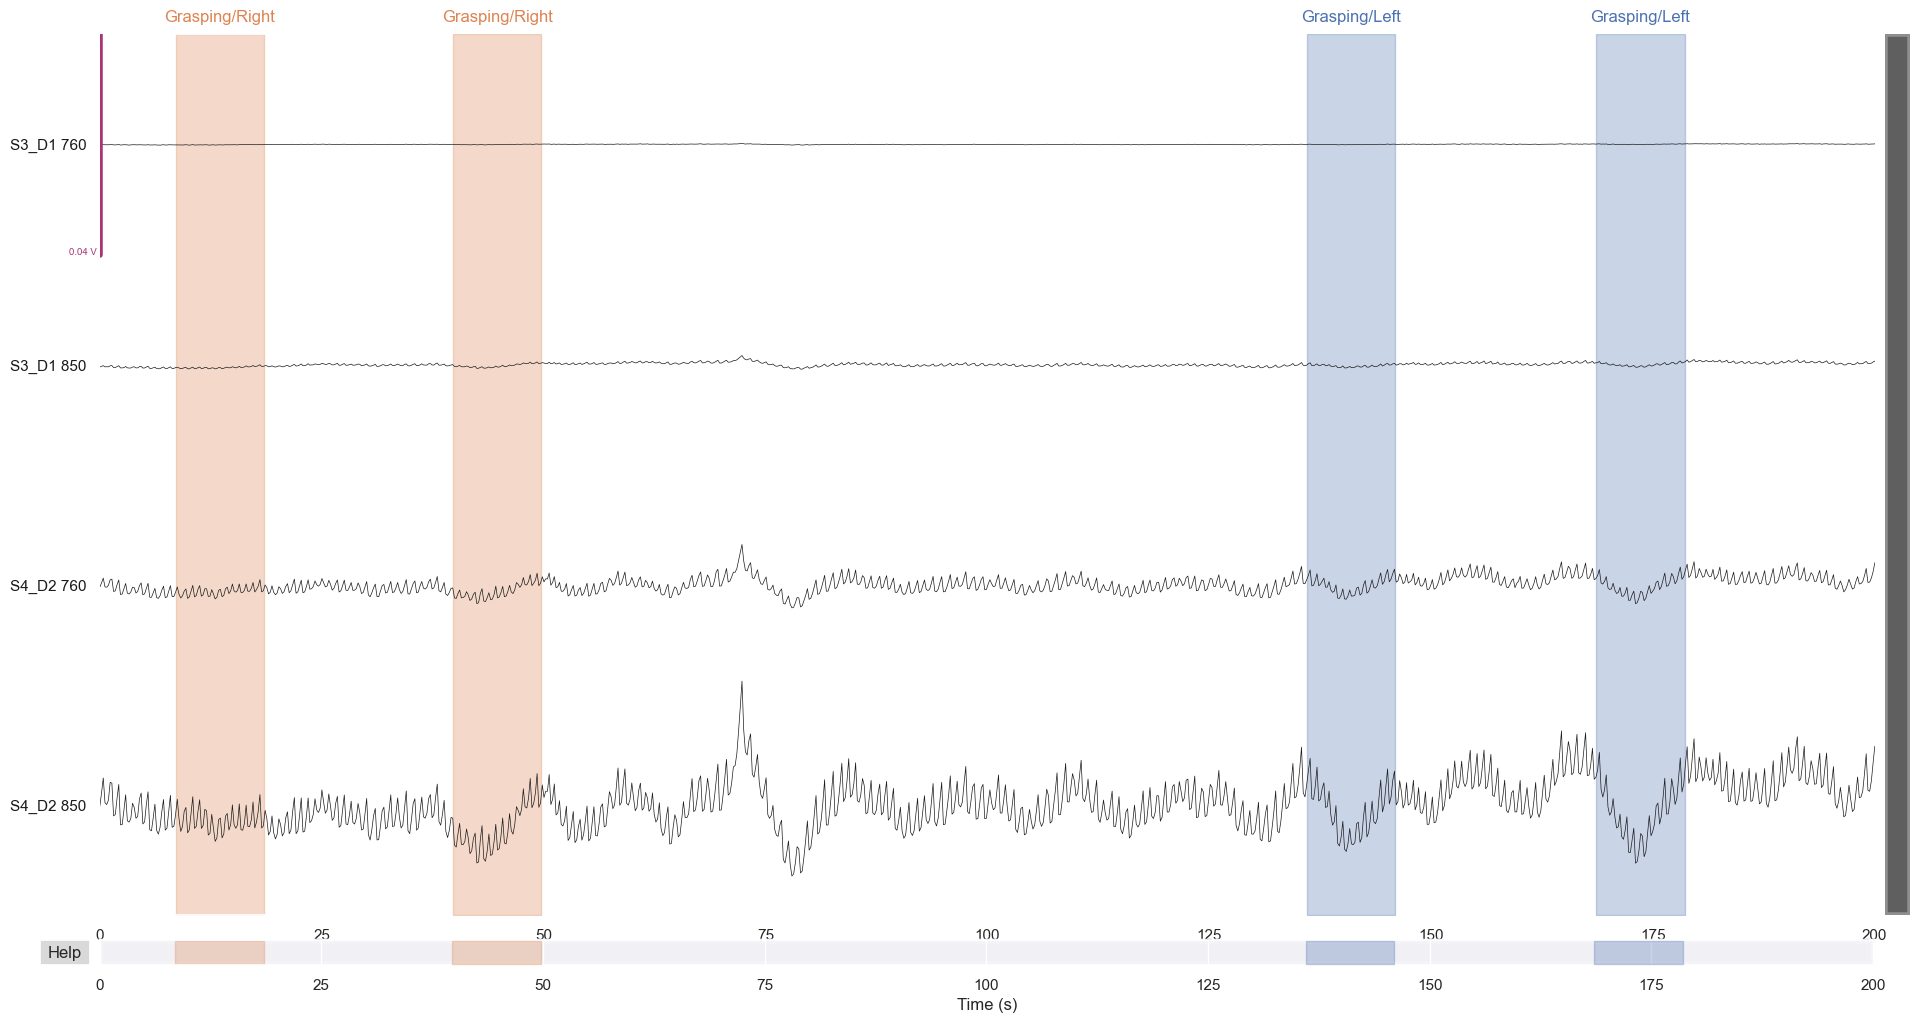

In [15]:
%matplotlib inline
fig = raw_intensity.copy().pick(np.arange(4,8)).crop(325,525).plot(duration=300, show_scrollbars = True, clipping = None)
if export:
    fig.savefig('FTT1_VI_1.png')

Focus more closely on the raw light intensity data of channel 4 to clearly visualize the noise present in the recording. The oscillations with a period of approximately 1 second (60 bpm) correspond to the participant's heart rate. Superimposed on these are oscillations with larger amplitudes and slower frequencies, around 10 Hz, likely attributed to Mayer waves. Additionally, a noticeable spike occurs a few seconds before the 50-second mark, probably resulting from head motion during the rest period.

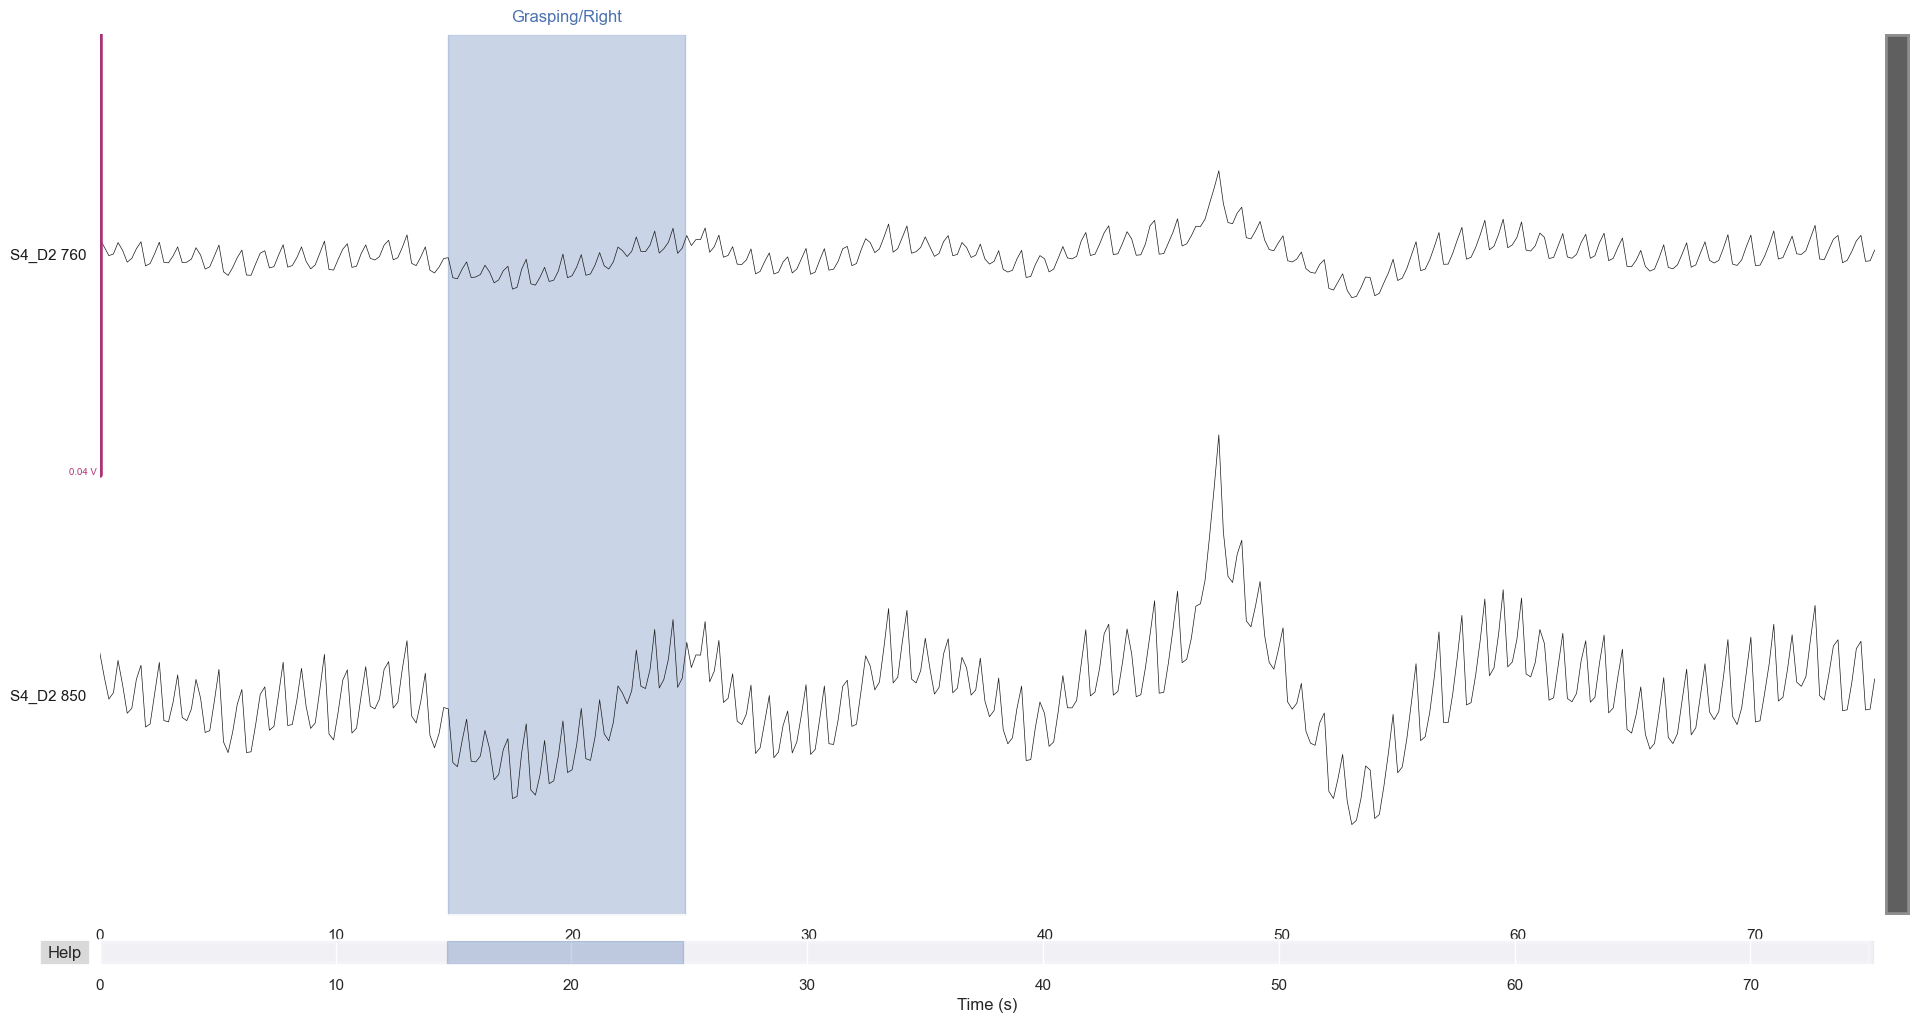

In [16]:
%matplotlib inline
fig = raw_intensity.copy().pick(np.arange(6,8)).crop(350,425).plot(duration=300, show_scrollbars = True, clipping = None)
if export:
    fig.savefig('FTT1_VI_2.png')

---
> *Remark:*
- Physiological components: Oscillations due to heart rate, Mayer waves
- Extrinsic components: Spikes due to motion
---

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [17]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_od = optical_density(raw_intensity)

Reading 0 ... 4393  =      0.000 ...   852.242 secs...


In [102]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od.plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- The same observations as in the light intensity data can be made.
---

##### Visual inspection of the haemoglobin concentration

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [18]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
# Separate long and short channels as we will only continue with long channels
min_dist = 0.01 
max_dist = 0.045
raw_h = beer_lambert_law(raw_od, ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.
raw_haemo_short = get_short_channels(raw_h, max_dist=max_dist)
raw_haemo = get_long_channels(raw_h, min_dist=min_dist, max_dist=max_dist)

In [104]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemo.plot(duration=300, show_scrollbars = True, clipping = None);

In the haemoglobin data, a clear difference in amplitude between HbO and HbR can be observed. Additionally, the two types of physiological noise (heart rate, Mayer waves) are again detectable. However, a closer look at the Mayer wave oscillations reveals an overlap between the Mayer wave frequency and the task frequency. This overlap results in inflated statistics, as the oscillation reaches its peak within the task intervals of 10 seconds. To illustrate this, the HbO data from channel S4_D6 is plotted between the time interval of 550 to 650 seconds, along with a sinusoidal curve of 0.09 Hz frequency that matches the amplitude and phase of the HbO data.

In [19]:
%matplotlib qt 
fig = raw_haemo.copy().pick(np.arange(23,31)).crop(550,650).plot(duration=300, show_scrollbars = True, clipping = None)

Channels marked as bad:
none


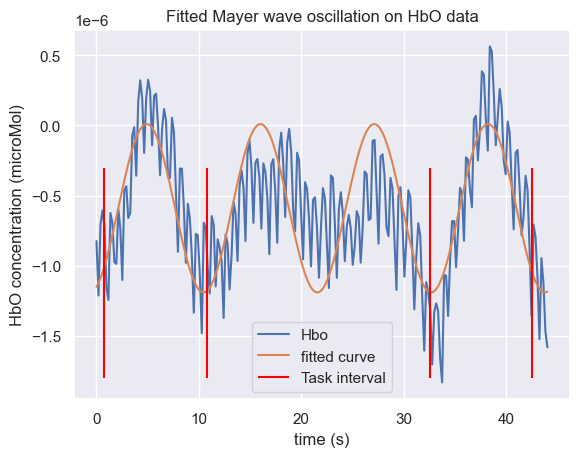

In [20]:
%matplotlib inline
data_channel_S4_D6_hbo = raw_haemo.copy().pick(picks = 26).crop(589,633).get_data()[0]
t = np.arange(len(data_channel_S4_D6_hbo))/raw_haemo.info['sfreq']
f = 0.09 # Hz
sin = 6e-7*np.sin(2*np.pi*f*t-1.2) + np.mean(data_channel_S4_D6_hbo)
start_interval = events[-6:-4,0]/raw_haemo.info['sfreq']-589
plt.plot(t, data_channel_S4_D6_hbo, label = 'Hbo') 
plt.plot(t, sin, label = 'fitted curve')
plt.vlines( [start_interval[0], start_interval[0] + raw_haemo.annotations.duration[0], start_interval[1], start_interval[1] + raw_haemo.annotations.duration[0]], ymin = -1.8e-6, ymax = -0.3e-6, color = 'red', label = 'Task interval')
plt.xlabel('time (s)')
plt.ylabel('HbO concentration (microMol)')
plt.title('Fitted Mayer wave oscillation on HbO data')
plt.legend()
if export:
    plt.savefig('FTT1_VI_4.png')

---
> *Remark:*
- The same observations as in the light intensity data can be made.
- Mayer waves inflate statistics.
---

#### Physiological noise <a class="anchor" id="sub_section_1_3_1"></a>

---
- Mayerwaves and heart beats are clearly visible
---

#### Spikes <a class="anchor" id="sub_section_1_3_2"></a>

---
- Spikes are present across multiple channels at timepoints: 304 s (S3-D5, S5-D5), 379 s (all channels)
---

#### Baseline shifts <a class="anchor" id="sub_section_1_3_3"></a>

---
- Not present  
---

#### Baseline drifts <a class="anchor" id="sub_section_1_3_4"></a>

---
- Not present 
---

### Signal quality metrics and channel rejection <a class="anchor" id="section_1_4"></a>

##### Separate long and short channels

In [21]:
raw_od_full = raw_od.copy()
raw_od_short = get_short_channels(raw_od, max_dist=max_dist)
raw_od = get_long_channels(raw_od, min_dist=min_dist, max_dist=max_dist)

#### Scalp Coupling Index <a class="anchor" id="sub_section_1_4_2"></a>

The SCI is a quality measurement of the connection between the optodes and the scalp of the participant using the strong cardiac oscillation in raw fNIRS signals. With a sufficiently high sampling rate (e.g.: 10 Hz), the heartbeat emerges as a dependable marker for evaluating optode-scalp coupling. It was first introduced by Pollonini et al. (2013) and it assesses the synchronous cardiac pulsation in the two photodetected signals (760 and 850 nm) in the cardiac band (0.5 - 2.5 Hz). After the bandpass-filtering the resulting signals are normalized to balance any difference between their amplitude. Finally, the zero-lag cross-correlation between photodetected signals of the same channel is used as a quantitative measure of the SNR of that specific channel. A threshold of SCI $>$ 0.75 is recommended by the authors.

Given that the frequency band of 0.5 - 2.5 Hz is quite broad and the participants are relatively at rest while seated, a FIR filter with a narrower band of 0.7 - 1.5 Hz is applied (40 bpm - 85 bpm). The transition band width at both the low and high cut-off frequencies is set to 0.3 Hz.

##### SCI evaluated over complete signal

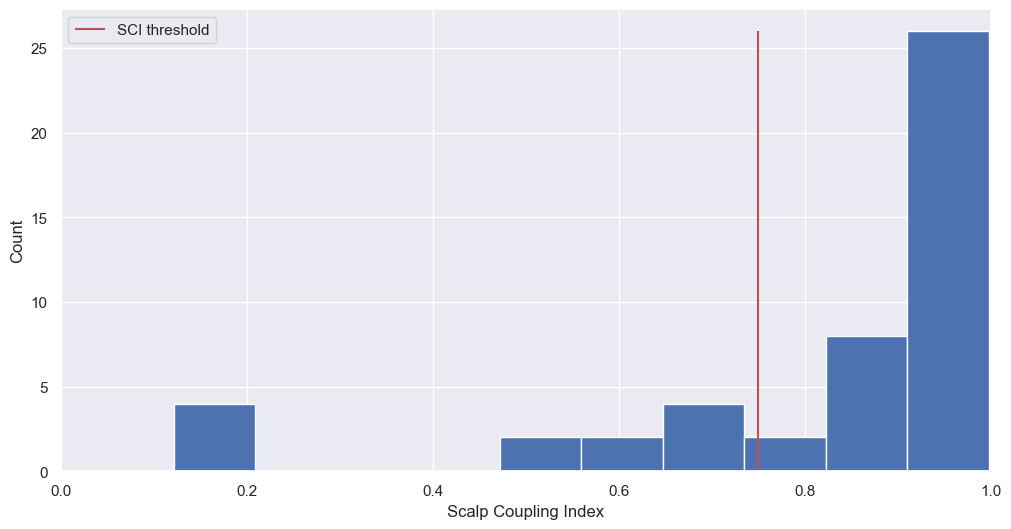

In [22]:
# Calculate SCI with build-in function of mne_nirs
sci = scalp_coupling_index(raw_od, l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False)
# SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

# Plot histogram of SCI values
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
plt.vlines(0.75, ymin = 0, ymax = 26, color = 'r', label = 'SCI threshold')
plt.legend()
if export:
    plt.savefig('FTT1_SCI.png')
plt.show()

In [23]:
# Copy raw object to apply SCI 
raw_od_SCI = raw_od.copy()
# Mark channels with SCI < 0.75 as BAD
raw_od_SCI.info['bads'] = list(compress(raw_od.ch_names, sci < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
print('The ' + str(len(raw_od_SCI.info['bads'])) + ' bad channels are: ' + str(raw_od_SCI.info['bads']))

The 12 bad channels are: ['S6_D4 760', 'S6_D4 850', 'S1_D7 760', 'S1_D7 850', 'S3_D7 760', 'S3_D7 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S8_D10 760', 'S8_D10 850']


In [25]:
# Inspect bad channels (grey color)
if plot:
    %matplotlib qt
    raw_od_SCI.plot(duration=300, show_scrollbars = True, clipping = None);

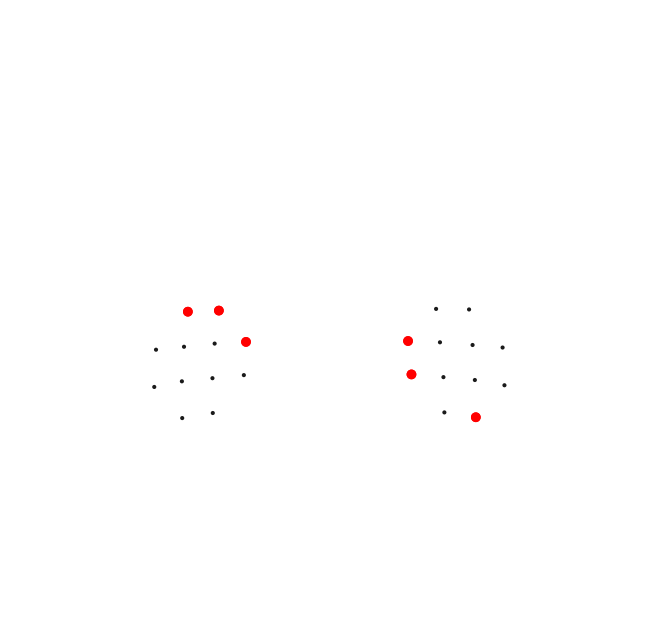

In [24]:
# Bad channels are now displayed in red
%matplotlib inline
raw_od_SCI.plot_sensors();

In [25]:
# Look at characteristics
raw_od_SCI

<RawSNIRF | FTT1.snirf, 48 x 4394 (852.2 s), ~1.7 MB, data loaded>

---
> *Remark:*
- 12 channels are marked as bad
- 4 of this bad channels have SCI score between 0.7 and and the threshold 0.75 
---

##### SCI evaluated over moving window

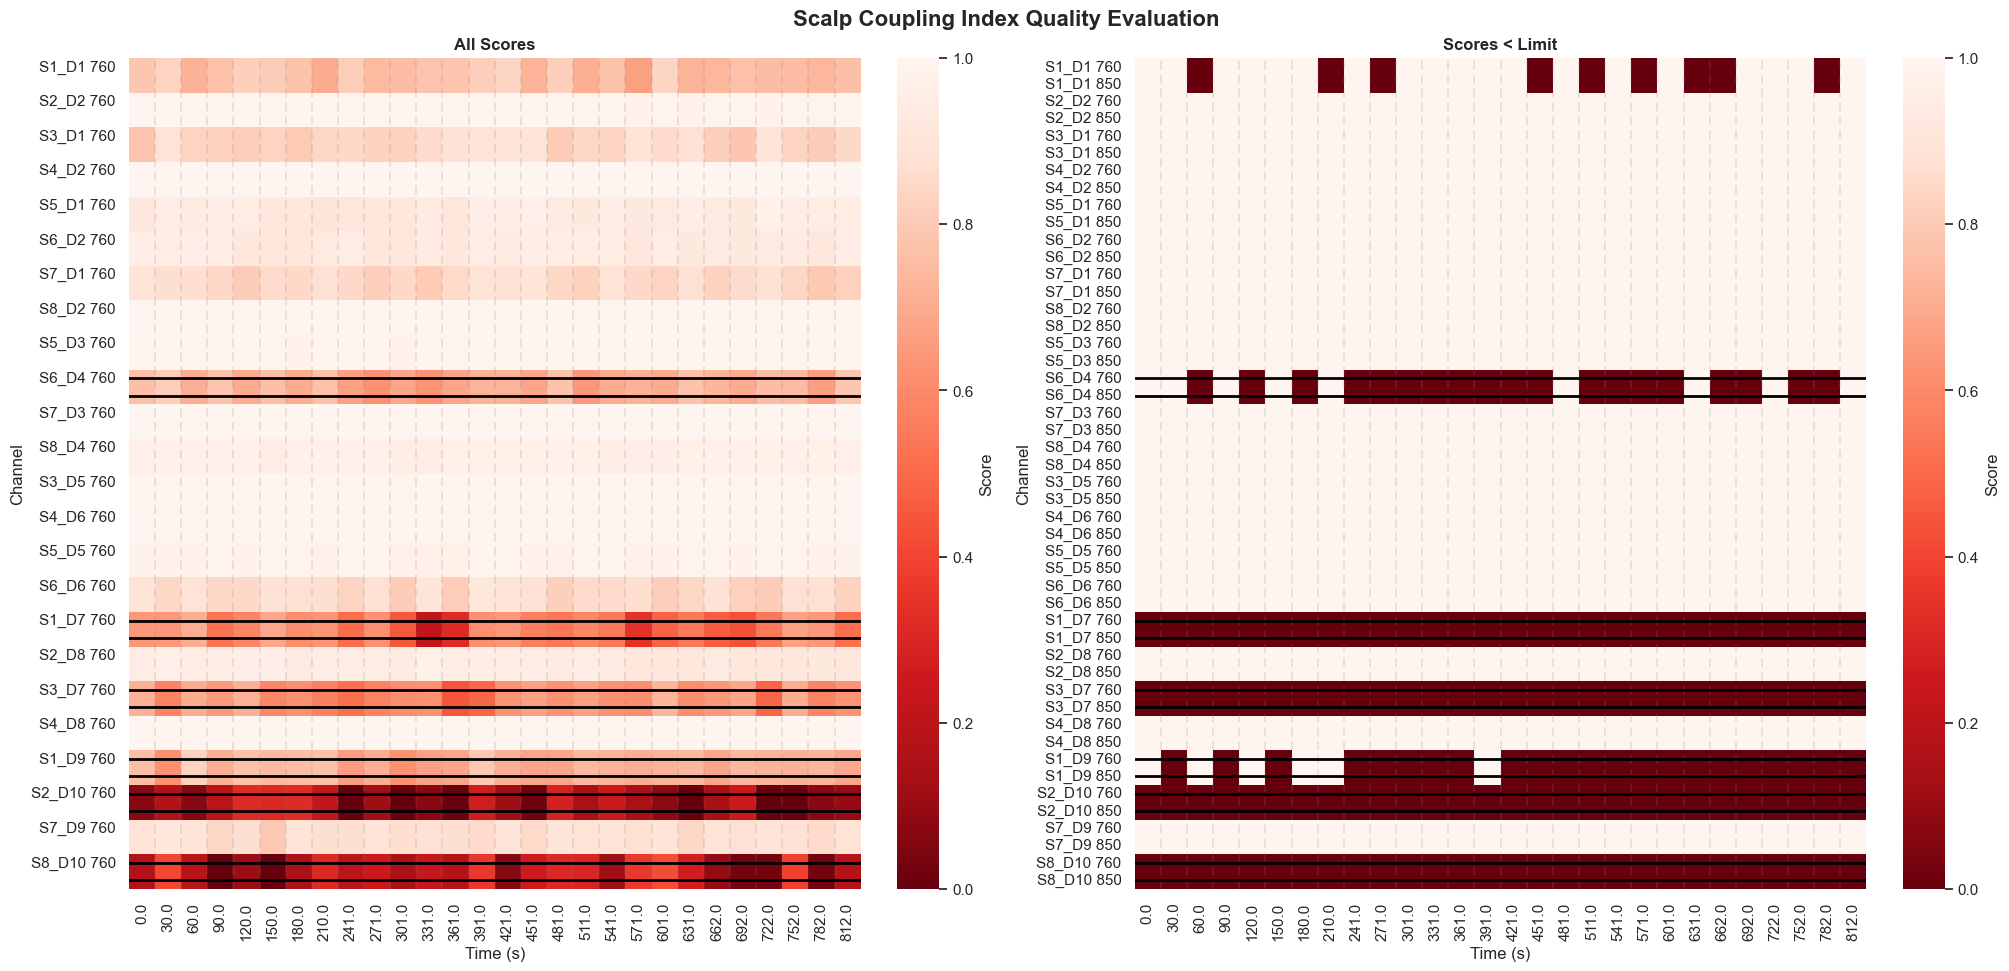

In [26]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_od_SCI, time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_od_SCI, scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

---
> *Remark:*
- 12 channels will be rejected for the full recording based on the SCI
- 2 channels have a bad SCI during certain intervals
---

#### Peak Spectral Power <a class="anchor" id="sub_section_1_4_3"></a>

Pollonini et al. (2016) state that to enhance the reliability of a quantitative measure for scalp coupling, the spectral power of the cross-correlated signal can serve as an additional indicator of cardiac signal strength. By setting a spectral power threshold, it becomes possible to objectively differentiate between a clear optical channel and a noisy one. Theoretically, photodetected cardiac signals can be conceptualized as two sinusoidal waves oscillating at the physiological frequency $f_{cardiac}$ (e.g.: 1 Hz or 60 bpm) with arbitrary amplitude and offset. The resultant normalized cross-correlation signal ($\overline{x_{\lambda_1}}  \otimes \overline{x_{\lambda_2}}$) exhibits unity amplitude, a frequency of $f_{cardiac}$ and a peak power of 0.5. Therefore, a threshold can be established at a certain fraction of the ideal peak power. However, in practice, cardiac photoplethysmographic signals are not strictly sinusoidal and may contain quantization noise, which reduces the peak power value. Hence, the authors recommend empirically setting the threshold value at 0.1.

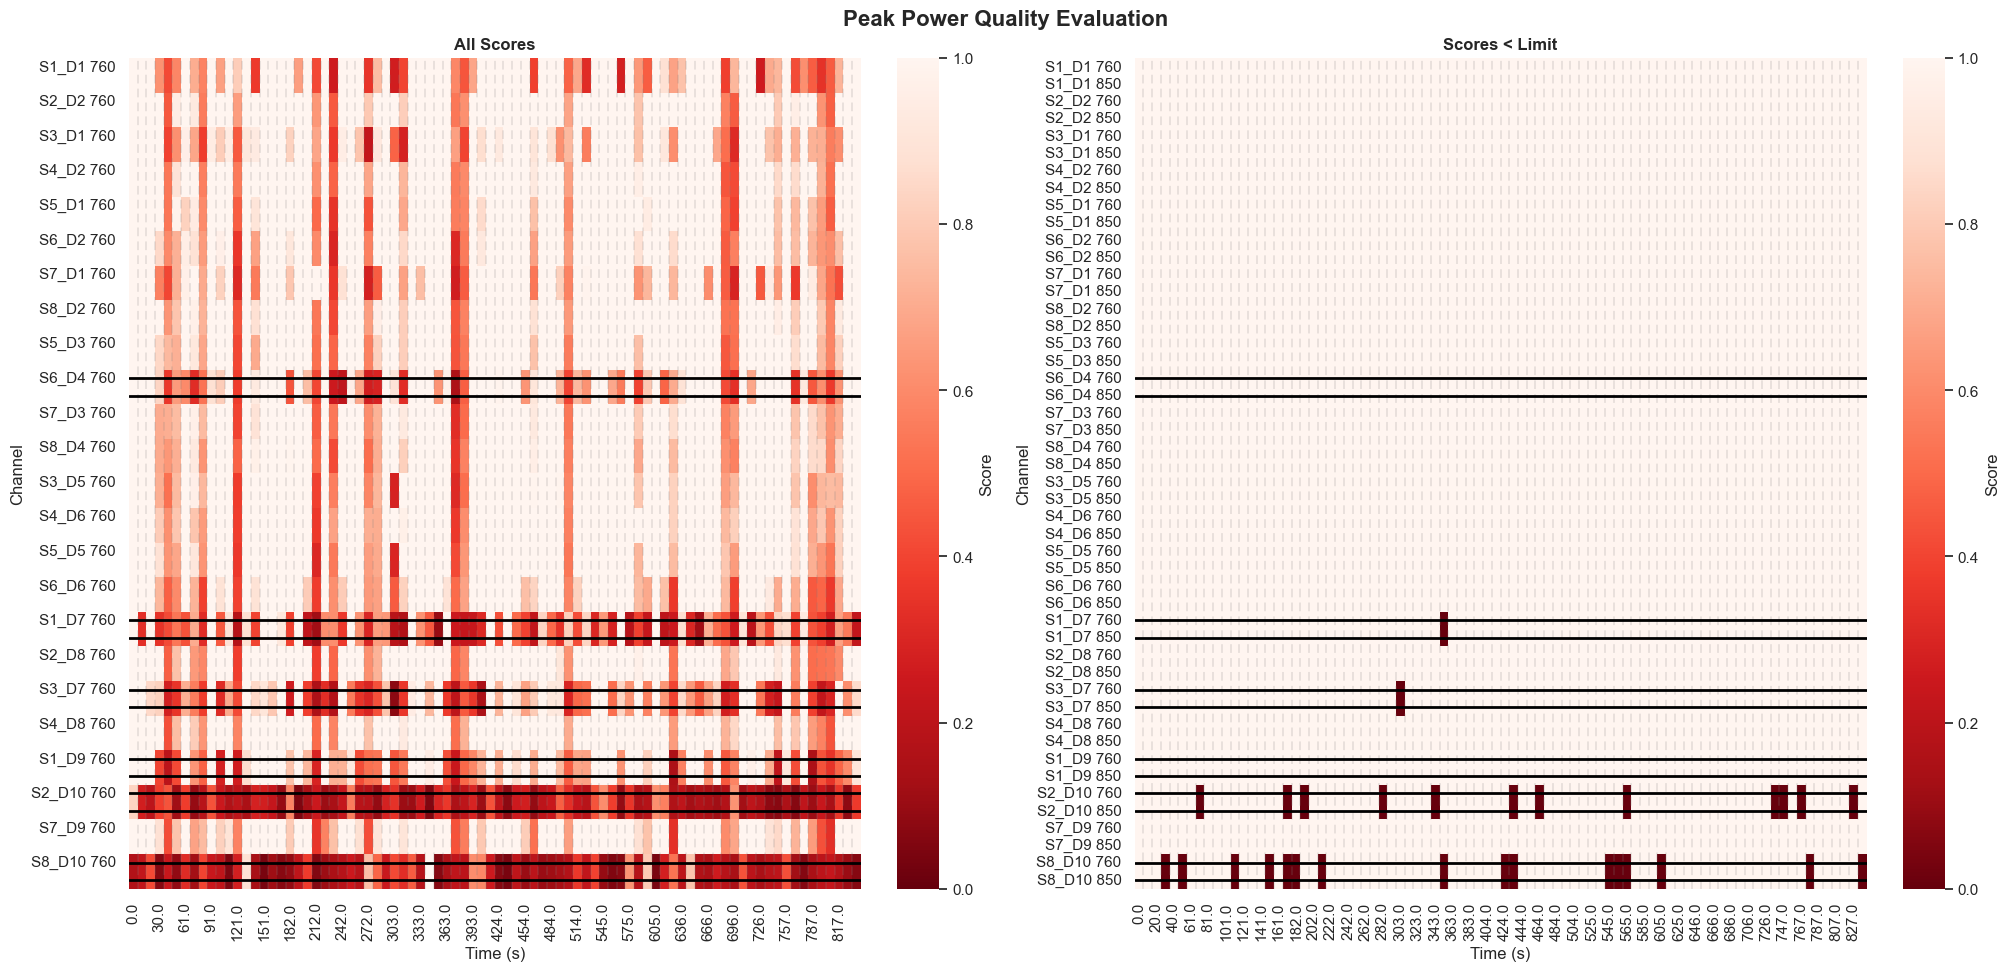

In [27]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCI, time_window=10)

# Plot
%matplotlib inline
plot_timechannel_quality_metric(raw_od_SCI_PSP, scores, times, threshold=0.1, title="Peak Power Quality Evaluation"); #see PHOEBE

In [30]:
# Check that PP was indicated where the bad segments of data are
if plot:
    %matplotlib qt
    raw_od_SCI_PSP.plot(duration=100, show_scrollbars = True, clipping = None);

In [28]:
# In dataframe format
raw_od_SCI_PSP.annotations.to_data_frame()

,onset,duration,description,ch_names
0,2024-02-15 13:12:48.000,10.0,Baseline,()
1,2024-02-15 13:12:49.000,10.0,Baseline,()
2,2024-02-15 13:13:01.000,10.0,Baseline,()
3,2024-02-15 13:13:04.000,10.0,Baseline,()
4,2024-02-15 13:13:06.264,10.0,BAD_PeakPower,"(S8_D10 760, S8_D10 850)"
5,2024-02-15 13:13:11.000,10.0,Baseline,()
6,2024-02-15 13:13:12.000,10.0,Baseline,()
7,2024-02-15 13:13:26.440,10.0,BAD_PeakPower,"(S8_D10 760, S8_D10 850)"
8,2024-02-15 13:13:27.000,10.0,Baseline,()
9,2024-02-15 13:13:28.000,10.0,Baseline,()


#### Signal-to-Noise Ratio <a class="anchor" id="sub_section_1_4_4"></a>

To calculate the SNR of the measured raw light within a fixed time window the following formula is used, with $\mu$ corresponding to the signal's intensity offset or DC component and $\sigma$ corresponding to the signal’s standard deviation or AC component (Yucel et al., 2021): 
$$SNR = 20 \log_{10}(\frac{\mu}{\sigma})$$

The SNR needs to be calculated on the raw intensity as the OD may have negative values due to the ln function. This technique can be used to assess the effect of correction algorithms are a threshold can be choosen, above which the SNR was to be.

##### SNR per channel

In [29]:
# SNR per channel
def SNR_ch(raw, plot = False, threshold = None):
    
    # SNR for channels
    SNR_ch = 10 * np.log10((np.mean(raw.get_data(), axis = 1)**2)/(np.std(raw.get_data(), axis = 1)**2))

    if plot:
        %matplotlib inline
        y_pos = range(len(raw.ch_names))
        plt.figure(figsize=(12,6))
        plt.bar(y_pos, SNR_ch)
        if threshold != None: 
            plt.hlines(threshold, xmin = -1, xmax = len(SNR_ch), color = 'r', label = 'Threshold')
        # Rotation of the bars names
        plt.xticks(y_pos, raw.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('SNR value (dB)')
        plt.title('SNR per channel')
        plt.legend()
        plt.show()
    
    return SNR_ch

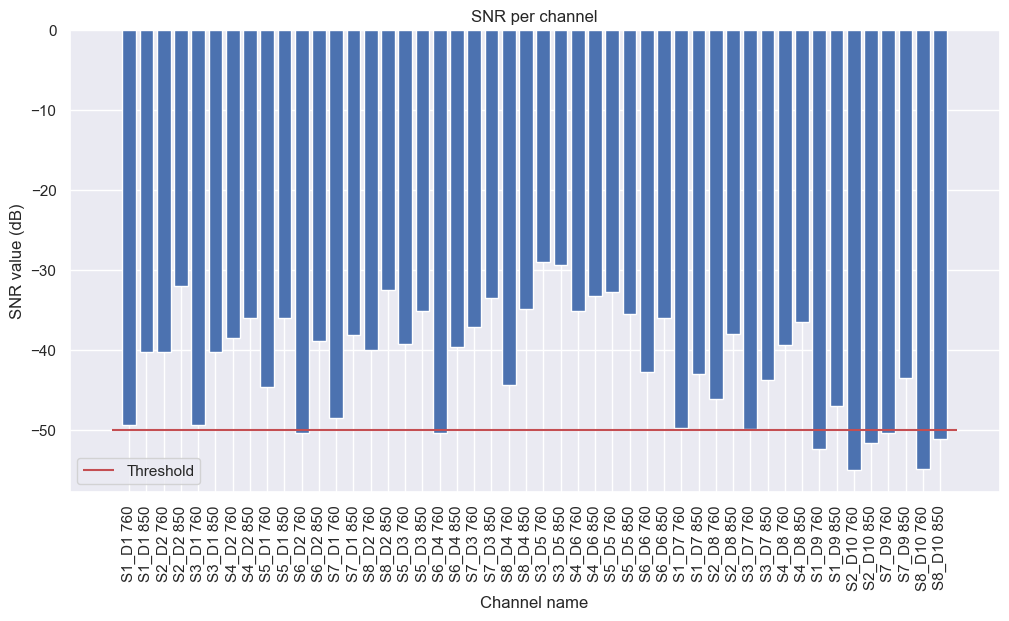

The 8 bad channels are: ['S6_D2 760', 'S6_D4 760', 'S1_D9 760', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S8_D10 760', 'S8_D10 850']


In [30]:
raw_od_SNR = raw_od.copy()
threshold = -50 # dB
snr_ch = SNR_ch(raw_od_SNR, plot = True, threshold = threshold)
# Mark channels with SNR < 10 dB as BAD
raw_od_SNR.info['bads'] = list(compress(raw_od_SNR.ch_names, snr_ch < threshold))
print('The ' + str(len(raw_od_SNR.info['bads'])) + ' bad channels are: ' + str(raw_od_SNR.info['bads']))

##### SNR over time window

In [31]:
# Define SNR function
def SNR(raw, time_window, threshold):
    raw_ = raw.copy()
    
    # make times
    window_samples = int(np.ceil(time_window * raw_.info['sfreq']))
    n_windows = int(np.floor(len(raw_) / window_samples))
    
    times = []
    for window in range(n_windows):
        start_sample = int(window * window_samples)
        end_sample = start_sample + window_samples
        end_sample = np.min([end_sample, len(raw) - 1])

        t_start = raw_.times[start_sample]
        t_stop = raw_.times[end_sample]
        times.append((t_start, t_stop))
    # make SNR scores
    scores = []
    for time in times:
        raw_segment = raw_.copy().crop(time[0], time[1])
        mu_sq = np.mean(raw_segment.get_data(), axis = 1)**2
        std_sq = np.std(raw_segment.get_data(), axis = 1)**2
        SNR = 10 * np.log10(mu_sq/std_sq)
        scores.append(SNR)

        for i in range(len(SNR)):
            if (threshold != None) and (SNR[i] < threshold):
                raw_.annotations.append(time[0], time_window, 'BAD_SNR',
                                       ch_names=[raw_.ch_names[i:i + 2]])
    return raw_, np.array(scores).T, times    

In [32]:
time_window = 30
threshold = -5
raw_od_SNR, scores, times = SNR(raw_od_SNR, time_window, threshold)

In [33]:
raw_od_SNR.annotations.to_data_frame()

,onset,duration,description,ch_names
0,2024-02-15 13:12:36.000,30.0,BAD_SNR,"(S4_D8 850, S1_D9 760)"
1,2024-02-15 13:12:48.000,10.0,Baseline,()
2,2024-02-15 13:12:49.000,10.0,Baseline,()
3,2024-02-15 13:13:01.000,10.0,Baseline,()
4,2024-02-15 13:13:04.000,10.0,Baseline,()
...,...,...,...,...
202,2024-02-15 13:23:37.540,30.0,BAD_SNR,"(S3_D1 850, S4_D2 760)"
203,2024-02-15 13:24:01.984,10.0,Grasping/Left,()
204,2024-02-15 13:24:07.610,30.0,BAD_SNR,"(S3_D1 850, S4_D2 760)"
205,2024-02-15 13:24:34.382,10.0,Grasping/Left,()


In [58]:
if plot:
    %matplotlib qt
    raw_od_SNR.plot(duration=100, show_scrollbars = True, clipping = None)

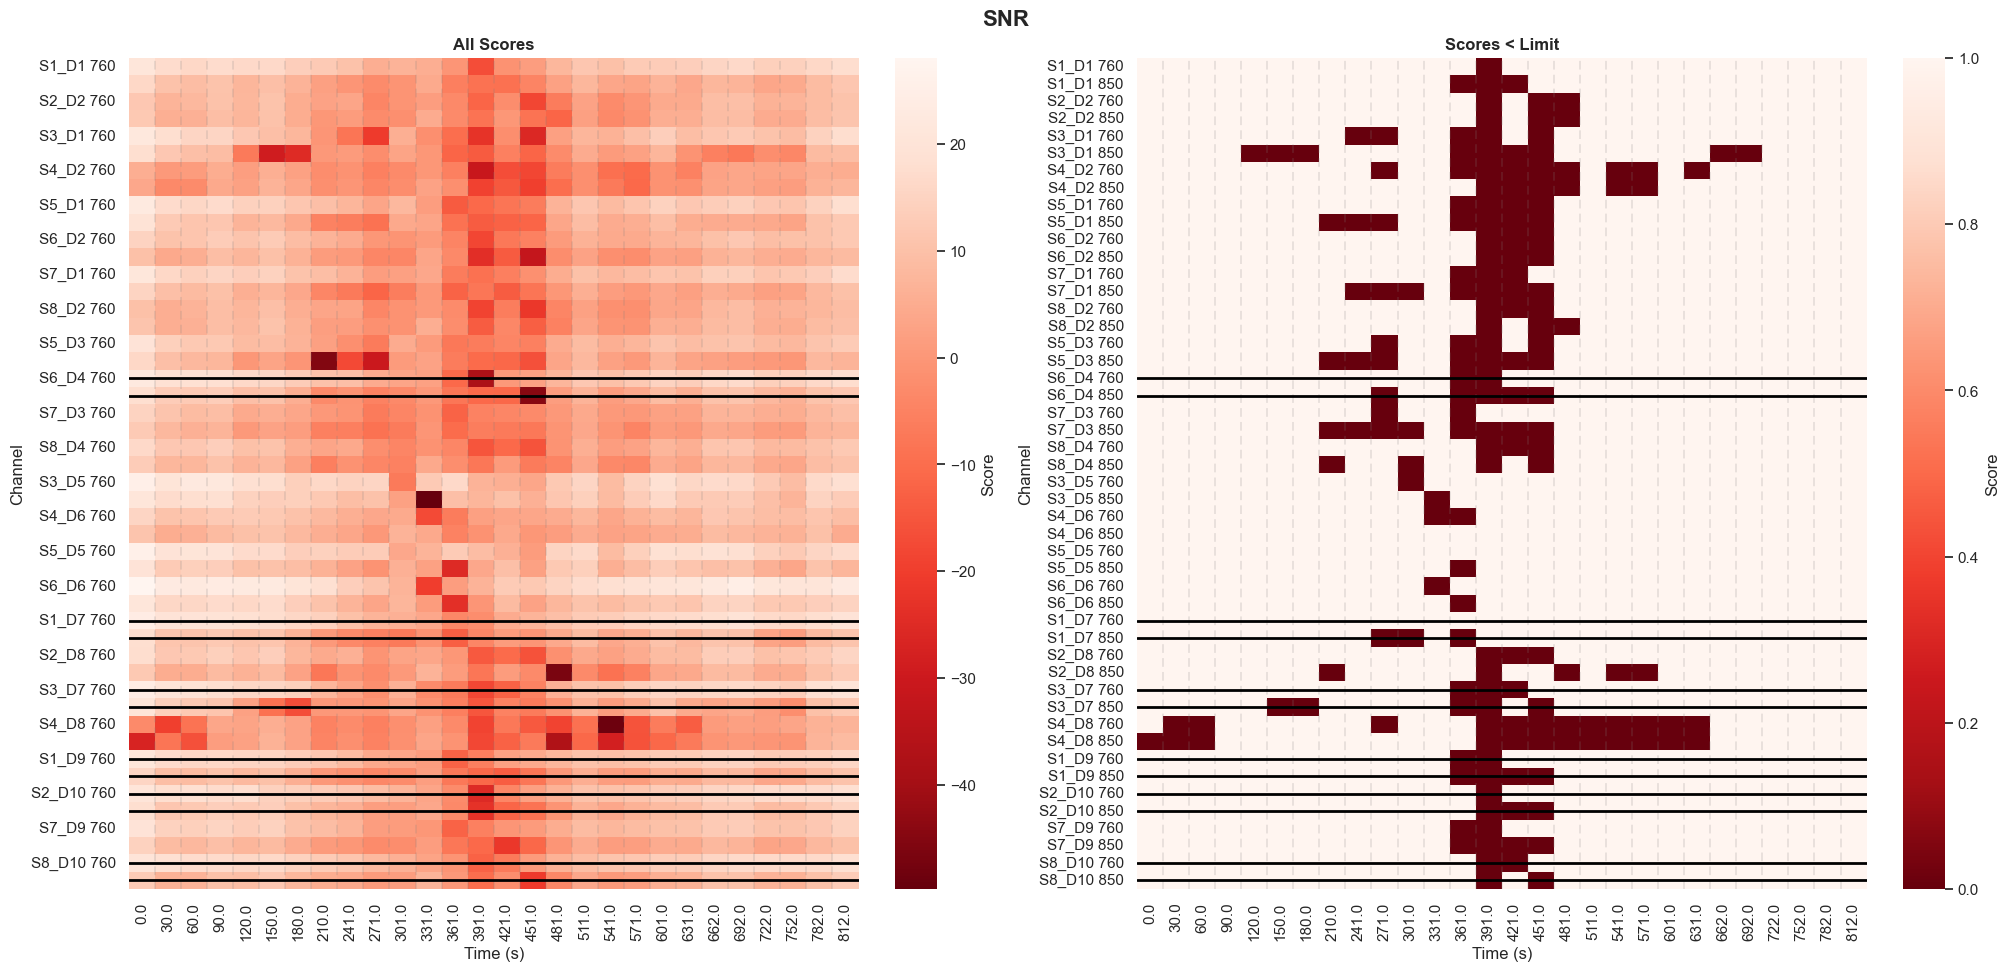

In [34]:
%matplotlib inline
fig = plot_SNR(raw_od_SCI, scores, times, threshold = threshold)
if export:
    plt.savefig('FTT1_SNR.png')

In [35]:
print('Timepoint start last hand grasping task before rest period: ' + str(events[19][0]/raw_od.info['sfreq']))
print('Timepoint start first hand grasping task after rest period: ' + str(round(events[20][0]/raw_od.info['sfreq'],2)))

Timepoint start last hand grasping task before rest period: 364.72
Timepoint start first hand grasping task after rest period: 460.94


---
> *Remark:*
- Low SNR for channels
- For a more detailed view SNR is performed over time windows, gives rise to better SNRs
- Bad channels of channelwise SNR do not overlap with SNR of time windows
- Clearly more noise during rest period
- Can be usefull to compare signal processing techniques
- Difficult to set threshold
- Could also be used with OD data if we set $SNR = 10 log_{10}(\frac{\mu^2}{\sigma^2})$
---

#### Coefficient of Variation <a class="anchor" id="sub_section_1_4_5"></a>

Another metric to estimate the SNR of a channel, is the relative coefficient of variation (CV). When the SNR of a channel decreases, the CV value will increase.
The CV is determined by dividing the standard deviation ($\sigma$) of the temporal changes in light intensity for a channel by the mean value ($\mu$), and then multiplying the result by 100 to express it as a percentage (Piper et al., 2014).
$$CV =  \frac{\sigma}{\mu} \cdot 100 \%$$

##### CV per channel

In [68]:
# DOI: 10.1016/j.neuroimage.2013.06.062
def CV_ch(raw, threshold = None, plot = False):
    
    # CV for channels
    CV_ch = 100*np.std(raw.get_data(), axis = 1)/np.mean(raw.get_data(), axis = 1)

    if plot:
        %matplotlib inline
        y_pos = range(len(raw.ch_names))
        plt.figure(figsize=(12,6))
        plt.bar(y_pos, CV_ch)
        if threshold != None: 
                plt.hlines(threshold, xmin = -1, xmax = len(CV_ch), color = 'r', label = 'Threshold')
        # Rotation of the bars names
        plt.xticks(y_pos, raw.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('CV value')
        plt.title('CV per channel')
        if threshold != None:
            plt.legend()
        plt.show()
    
    return CV_ch

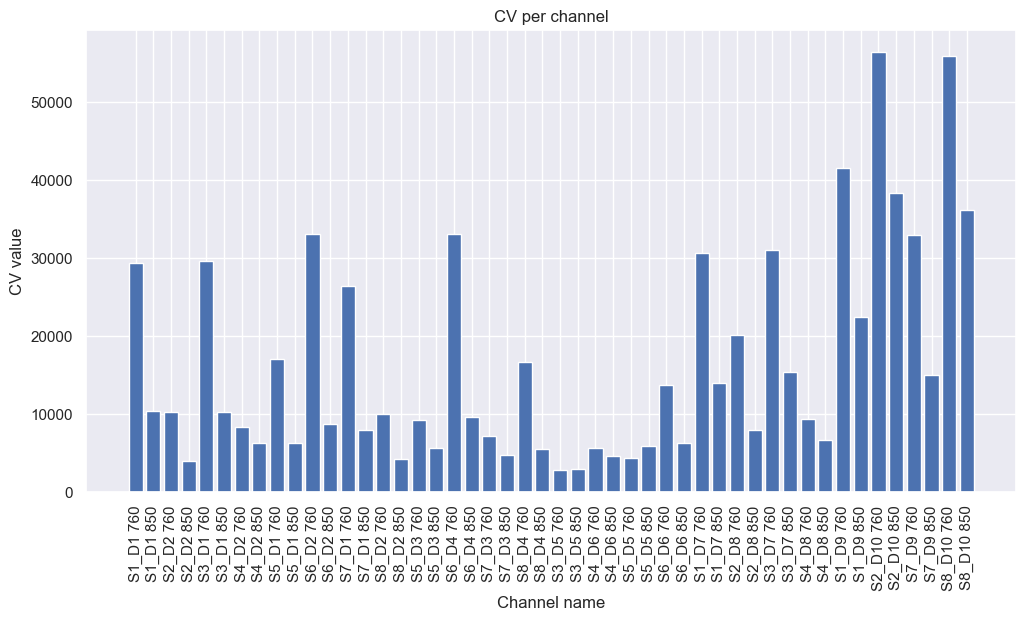

In [69]:
raw_od_CV = raw_od.copy()
threshold = None
CV_channels = CV_ch(raw_od_CV, threshold = threshold, plot = True)
# # Mark channels with CV > 40000 as BAD
# raw_od.info['bads'] = list(compress(raw_od.ch_names, CV_channels > threshold))
# print('The ' + str(len(raw_od.info['bads'])) + ' bad channels are: ' + str(raw_od.info['bads']))


##### CV over time window

In [70]:
# Define SNR function
def CV(raw, time_window, threshold):
    raw_ = raw.copy()
    
    # make times
    window_samples = int(np.ceil(time_window * raw_.info['sfreq']))
    n_windows = int(np.floor(len(raw_) / window_samples))
    
    times = []
    for window in range(n_windows):
        start_sample = int(window * window_samples)
        end_sample = start_sample + window_samples
        end_sample = np.min([end_sample, len(raw) - 1])

        t_start = raw_.times[start_sample]
        t_stop = raw_.times[end_sample]
        times.append((t_start, t_stop))
    # make CV scores
    scores = []
    for time in times:
        raw_segment = raw_.copy().crop(time[0], time[1])
        mu = np.mean(raw_segment.get_data(), axis = 1)
        std = np.std(raw_segment.get_data(), axis = 1)
        CV = 100*std/mu
        scores.append(CV)

        for i in range(len(CV)):
            if (threshold != None) and (CV[i] > threshold):
                raw_.annotations.append(time[0], time_window, 'BAD_CV',
                                       ch_names=[raw_.ch_names[i:i + 2]])
    return raw_, np.array(scores).T, times    

In [71]:
time_window = 30
threshold = 2
raw_od_CV, scores, times = CV(raw_od_CV, time_window, threshold)

In [72]:
raw_od_CV.annotations.to_data_frame()

,onset,duration,description,ch_names
0,2024-02-15 13:12:36.000,30.0,BAD_CV,"(S1_D1 760, S1_D1 850)"
1,2024-02-15 13:12:36.000,30.0,BAD_CV,"(S1_D1 850, S2_D2 760)"
2,2024-02-15 13:12:36.000,30.0,BAD_CV,"(S2_D2 760, S2_D2 850)"
3,2024-02-15 13:12:36.000,30.0,BAD_CV,"(S2_D2 850, S3_D1 760)"
4,2024-02-15 13:12:36.000,30.0,BAD_CV,"(S3_D1 760, S3_D1 850)"
...,...,...,...,...
677,2024-02-15 13:22:57.576,10.0,Grasping/Left,()
678,2024-02-15 13:23:29.974,10.0,Grasping/Left,()
679,2024-02-15 13:24:01.984,10.0,Grasping/Left,()
680,2024-02-15 13:24:34.382,10.0,Grasping/Left,()


In [45]:
if plot:
    %matplotlib qt
    raw_od_CV.plot(duration=100, show_scrollbars = True, clipping = None)

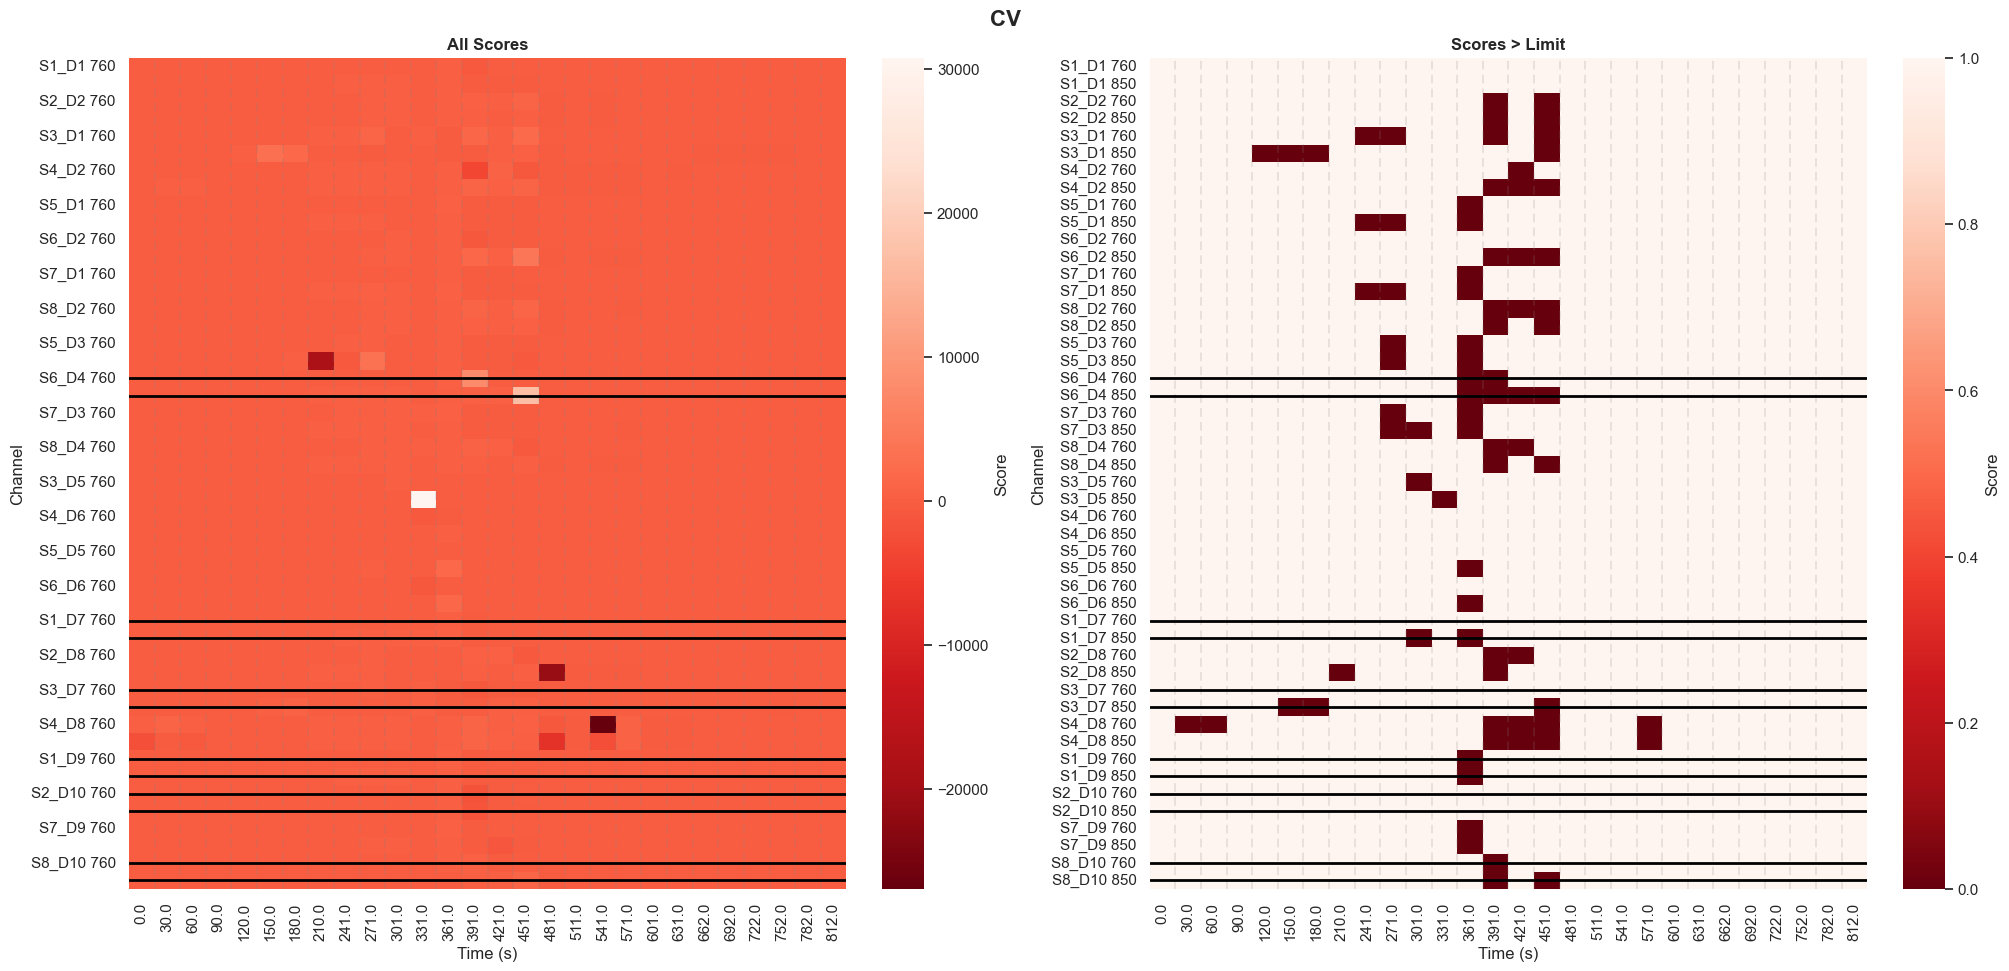

In [78]:
%matplotlib inline
fig = plot_CV(raw_od_SCI, scores, times, threshold = 200)
if export:
    plt.savefig('FTT1_CV.png')

---
> *Remark:*
- Extreme high values for CV of channels and large differences between channels
- Working with time windows does not solve the issue
- Again setting threshold is not straight forward 
---

#### Contrast-to-Noise Ratio <a class="anchor" id="sub_section_1_4_6"></a>

When assessing the relationship between the strength of an extracted haemodynamic response and background confounding signals or measurement noise, contrast metrics like contrast-to-noise ratio (CNR) are employed. 
CNR is often used in fNIRS studies although different definitions are used. In some studies (Cui et al., 2011; Nguyen et al., 2018; Huang et al., 2022), the CNR is computed by determining the amplitude difference between the signal during task blocks and control or rest blocks, which is then divided by the pooled standard deviation. Therefore, a higher absolute CNR suggests a greater ratio of task-related signal to noise. 
$$CNR = \frac{mean(task)-mean(rest)}{\sqrt{var(task)+var(rest)}}$$

In [79]:
#different approaches possible! this one is from doi: 10.1016/j.neuroimage.2010.10.069
def CNR(raw, controls_id, trials_id, threshold = None, plot = False):
    events, _ = mne.events_from_annotations(raw)

    start_trials = []
    if type(trials_id) != list:
        raise Exception("Event ids must be in list format")
    for id in trials_id:
        start_trials += list(events[events[:,2] == id][:,0]/raw.info['sfreq'])
    start_trials = np.array(start_trials)

    start_controls = []
    if type(controls_id) != list:
        raise Exception("Event ids must be in list format")
    for id in controls_id:
        start_controls += list(events[events[:,2] == id][:,0]/raw.info['sfreq'])
    start_controls = np.array(start_controls)

    mean_trials = np.zeros((len(start_trials), len(raw.ch_names)))
    var_trials = np.zeros((len(start_trials), len(raw.ch_names)))

    for i, start in enumerate(start_trials):
        raw_CNR = raw.copy()
        trial = raw_CNR.crop(tmin=start, tmax=(start+raw.annotations.duration[0])).get_data()
        mean_trials[i] = np.mean(trial, axis = 1)
        var_trials[i] = np.var(trial, axis = 1)

    mean_controls = np.zeros((len(start_controls), len(raw.ch_names)))
    var_controls = np.zeros((len(start_controls), len(raw.ch_names)))
    
    for i, start in enumerate(start_controls):
        raw_CNR = raw.copy()
        control = raw_CNR.crop(tmin=start, tmax=(start+raw.annotations.duration[0])).get_data()
        mean_controls[i] = np.mean(control, axis = 1)
        var_controls[i] = np.var(control, axis = 1)

    CNR = (np.mean(mean_trials, axis = 0) - np.mean(mean_controls, axis = 0))/np.sqrt(np.mean(var_trials, axis = 0) + np.mean(var_controls, axis = 0))

    if plot:
        %matplotlib inline
        y_pos = range(len(raw.ch_names))
        plt.figure(figsize=(12,6))
        plt.bar(y_pos, np.abs(CNR))
        if threshold != None: 
            plt.hlines(threshold, xmin = -1, xmax = len(CNR), color = 'r', label = 'Threshold')
        # Rotation of the bars names
        plt.xticks(y_pos, raw.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('CNR value')
        if threshold != None: 
            plt.legend()
        plt.title('Absolute CNR')
        if export:
            plt.savefig('FTT1_CNR.png')
        plt.show()

    return CNR

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


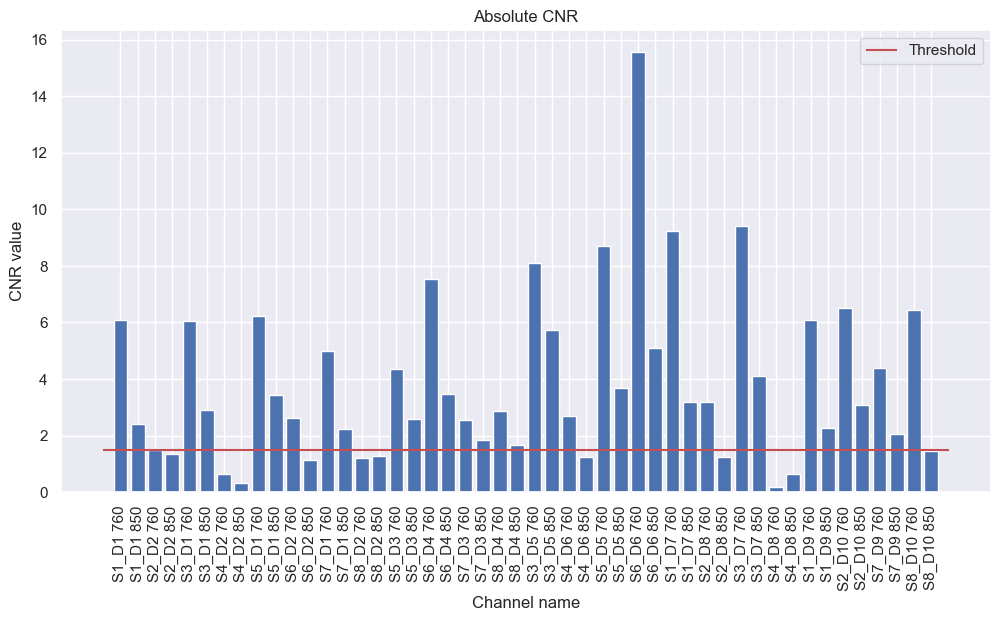

The 12 bad channels are: ['S2_D2 760', 'S2_D2 850', 'S4_D2 760', 'S4_D2 850', 'S6_D2 850', 'S8_D2 760', 'S8_D2 850', 'S4_D6 850', 'S2_D8 850', 'S4_D8 760', 'S4_D8 850', 'S8_D10 850']
The 12 bad channels of SCI are: ['S6_D4 760', 'S6_D4 850', 'S1_D7 760', 'S1_D7 850', 'S3_D7 760', 'S3_D7 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S8_D10 760', 'S8_D10 850']


In [81]:
raw_od_CNR = raw_od.copy()
threshold = 1.5
cnr = CNR(raw_od_CNR, [1], [2,3], threshold = threshold, plot = True)
# Mark channels with CV > 40000 as BAD
raw_od_CNR.info['bads'] = list(compress(raw_od_CNR.ch_names, np.abs(cnr) < threshold))
print('The ' + str(len(raw_od_CNR.info['bads'])) + ' bad channels are: ' + str(raw_od_CNR.info['bads']))
print('The ' + str(len(raw_od_SCI.info['bads'])) + ' bad channels of SCI are: ' + str(raw_od_SCI.info['bads']))

---
> *Remark:*
- CNR can also have negative values so to compare against a threshold absolute values are used
- Again setting threshold is difficult 
---